# Figure 3
## A Dotplot for GSEA NES

In [62]:
library(ggplot2)
library(ggrepel)
library(ggthemes)
library(ggsci)
library(dplyr)

In [40]:
load('data/hpv_deseq2_gsea.Rdata')
NES_RNA<- hpv_gsea_gobp%>% dplyr::select(pathway,padj,NES,size)
load('data/hpv_protein_gsea.Rdata')
NES_protein <- hpv_gsea_gobp_protein%>% dplyr::select(pathway,padj,NES,size)
data <- merge(NES_RNA,NES_protein,by='pathway')

In [50]:
rnaset=1
proteinset=1
data$group=ifelse( data$padj.x<0.05 & data$padj.y<0.05 & abs(data$NES.x)>=1.5 & abs(data$NES.y)>=1.5,'double_sig','stable')
NES=data[,c(1,3,6,8)]
colnames(NES)=c('pathway','RNA','Protein','group')
NES$size=ifelse( NES$group=='stable',0.1,abs(NES$RNA))
NES$alpha=ifelse( NES$group=='stable',0.001,0.4)

In [61]:
select=c( "GOBP_CELL_CYCLE_DNA_REPLICATION",'GOBP_T_CELL_MEDIATED_IMMUNITY','GOBP_B_CELL_MEDIATED_IMMUNITY','GOBP_INTERFERON_GAMMA_MEDIATED_SIGNALING_PATHWAY',
         'GOBP_ADAPTIVE_IMMUNE_RESPONSE','GOBP_EXTRACELLULAR_MATRIX_ASSEMBLY','GOBP_CELL_SUBSTRATE_ADHESION',
         'GOBP_ENDODERM_DEVELOPMENT','GOBP_CELL_MORPHOGENESIS','GOBP_CELL_CELL_JUNCTION_ASSEMBLY')

In [63]:
options(repr.plot.width=8, repr.plot.height=6)
pdot=ggplot(data=NES, aes(x=RNA, y=Protein,color=group))+geom_point(aes(alpha=alpha),size=1.5)+
labs(x = "NES(RNA)", y = "NES(PROTEIN)", title = "HPV_Integration")+
scale_color_npg()+
  theme_classic()+scale_size_continuous(range=c(1,5))+
  scale_x_continuous(limits = c(-3.2,3.2),expand = c(0,0))+
  scale_y_continuous(limits = c(-3,3),expand = c(0,0))+
geom_text_repel(aes(x=RNA, y=Protein,label = ifelse( pathway%in%select & group!='stable', pathway,"")),
        colour="darkred", box.padding = unit(0.35, "lines"), size=4,max.overlaps=500,
        point.padding = unit(1, "lines"))+
geom_vline(xintercept = c(-1.5,1.5), color="grey40", 
             linetype="longdash", lwd = 0.5) + #虚线的形状和粗细
geom_hline(yintercept = c(-1.5,1.5), color="grey40", 
             linetype="longdash", lwd = 0.5)

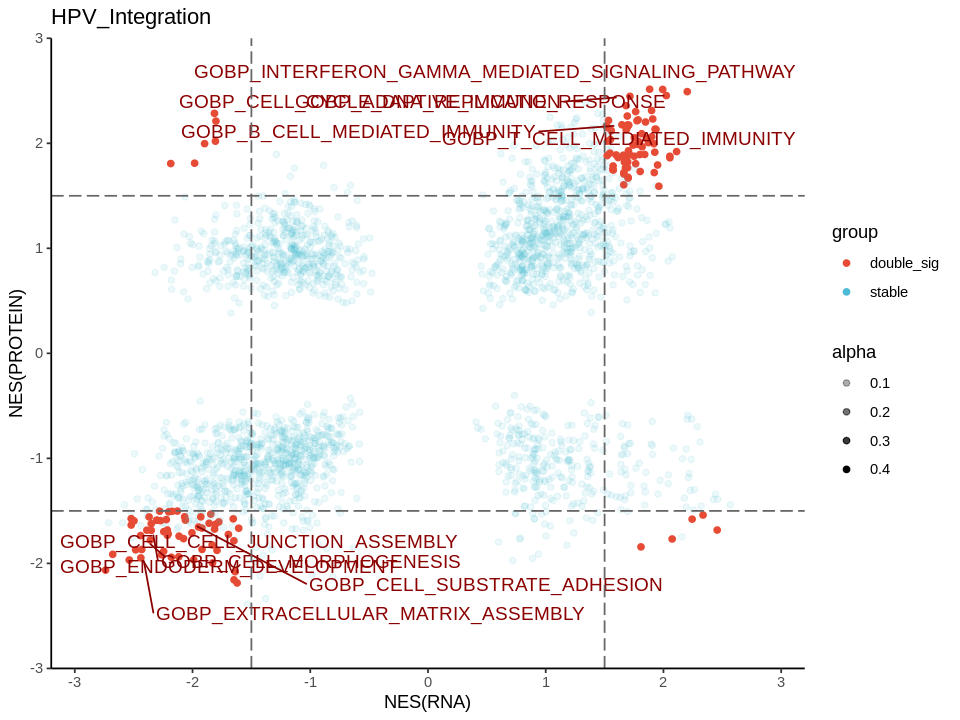

In [64]:
pdot

## B GSEAplot

In [74]:
library(ggplot2)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(ggsci)

In [76]:
deg <- read.csv('data/hpv_deg.csv',header = T,row.names=1)
hallmark=read.csv('data/hallmark_genelist.csv',header=T,row.names = 1)

In [77]:
deg$symbol=rownames(deg)
df <- bitr(deg$symbol, fromType = "SYMBOL",
           toType = c( "ENTREZID"),
           OrgDb = org.Hs.eg.db)
geneList2=merge(deg,df,by.x='symbol',by.y='SYMBOL')
geneList2 <- geneList2[order(geneList2$log2FoldChange,decreasing = T),]
geneList <- geneList2$log2FoldChange
names(geneList)<-geneList2$symbol

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(deg$symbol, fromType = "SYMBOL", toType = c("ENTREZID"), :
“1.55% of input gene IDs are fail to map...”


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


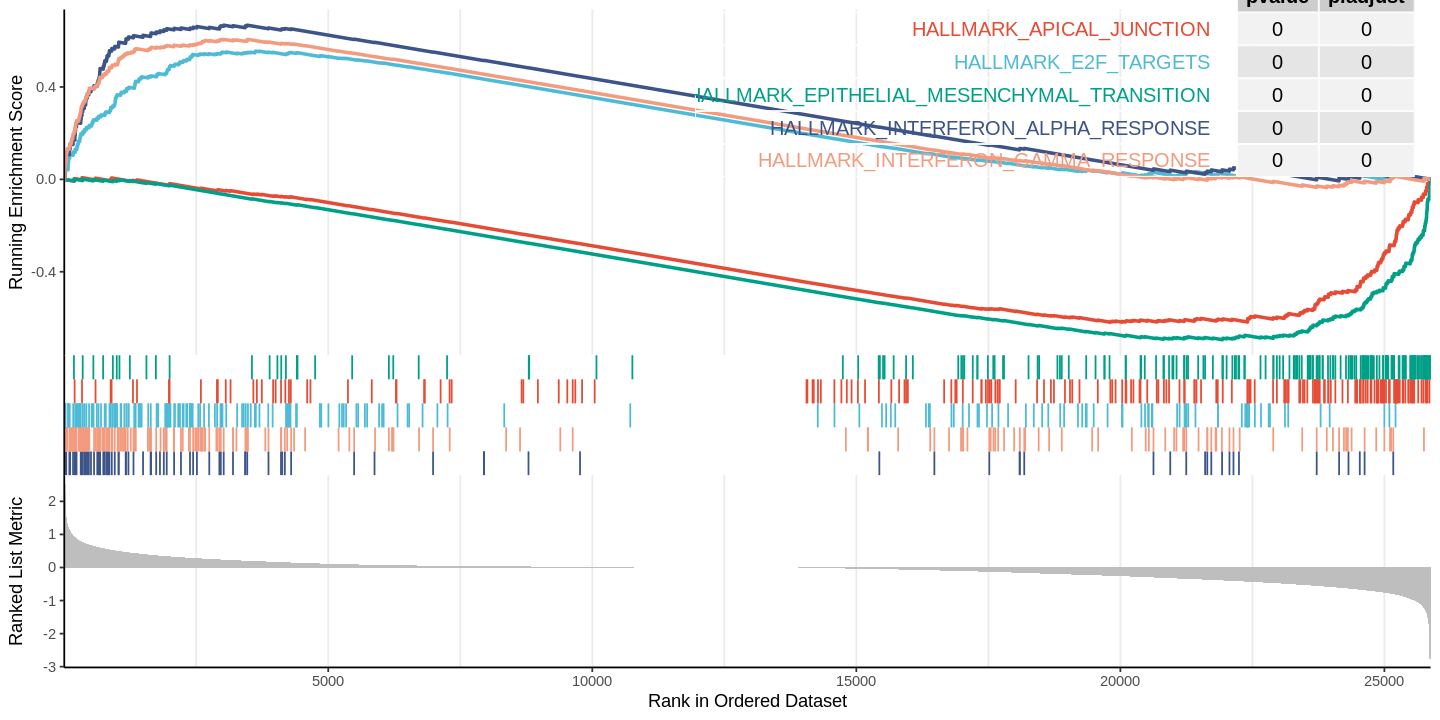

In [78]:
y <- GSEA(geneList, TERM2GENE = hallmark ,pvalueCutoff = 0.1,verbose = F)
options(repr.plot.width=12, repr.plot.height=6)
gseaplot2(y, geneSetID = c('HALLMARK_INTERFERON_ALPHA_RESPONSE',
                           'HALLMARK_INTERFERON_GAMMA_RESPONSE','HALLMARK_E2F_TARGETS',
                           'HALLMARK_APICAL_JUNCTION','HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'),
          pvalue_table = T,color = pal_npg()(5))

## C xCELL score

In [126]:
library(ggplot2)
library(ggsignif)
library(ggpubr)
library(ggthemes)
library(ggunchained) 
library(reshape2)  


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




In [125]:
xcell <- read.csv('data/hpv_xcell.csv',header = T,row.names = 1)
select=c('CD4+ T-cells','Macrophages M2','Memory B-cells','CD8+ Tem','pro B-cells','CD4+ memory T-cells','pDC','B-cells','CD8+ Tcm','ImmuneScore')

In [129]:
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
  library(plyr)
  
  # New version of length which can handle NA's: if na.rm==T, don't count them
  length2 <- function (x, na.rm=FALSE) {
    if (na.rm) sum(!is.na(x))
    else       length(x)
  }
  
  # This does the summary. For each group's data frame, return a vector with
  # N, mean, and sd
  datac <- ddply(data, groupvars, .drop=.drop,
                 .fun = function(xx, col) {
                   c(N    = length2(xx[[col]], na.rm=na.rm),
                     median = median   (xx[[col]], na.rm=na.rm),
                     sd   = sd     (xx[[col]], na.rm=na.rm)
                   )
                 },
                 measurevar
  )
  
  # Rename the "mean" column    
  datac <- rename(datac, c("median" = measurevar))
  
  datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean
  
  # Confidence interval multiplier for standard error
  # Calculate t-statistic for confidence interval: 
  # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
  ciMult <- qt(conf.interval/2 + .5, datac$N-1)
  datac$ci <- datac$se * ciMult
  
  return(datac)
}

In [133]:
Data_summary <- summarySE(xcell, measurevar="composition", groupvars=c("integrate","cell_type"))

In [131]:
df=xcell[ xcell$cell_type%in%select,]
df$cell_type=factor(df$cell_type)
pjitter=ggplot(df,aes(x=cell_type, y=composition,fill=integrate)) + 
  geom_jitter(aes(color = integrate), trim = FALSE,
    binaxis='y', stackdir='center', size=2,
    position = position_dodge(0.8))+
  geom_point(data = Data_summary[Data_summary$cell_type%in%select,],aes(x=cell_type, y=composition),color='black',pch=19,position=position_dodge(0.9),size=1.5)+ #绘制均值为点图
  geom_errorbar(data = Data_summary[Data_summary$cell_type%in%select,],aes(ymin = composition-sd, ymax=composition+sd), #误差条表示95%的置信区间
                width=0.1, #误差条末端短横线的宽度
                position=position_dodge(0.9), 
                alpha = 0.7,color='black',
                size=0.5) +
  scale_color_npg()+
  stat_compare_means(method = "wilcox.test",label = "p.format")+
  theme_bw()+ #背景变为白色
  scale_y_continuous(limits=c(0,0.6))+
  theme(axis.text.x=element_text(angle=45,hjust = 1,colour="black",size=12), #设置x轴刻度标签的字体显示倾斜角度为15度，并向下调整1(hjust = 1)，字体簇为Times大小为20
        axis.text.y=element_text(,size=12,face="plain"), #设置y轴刻度标签的字体簇，字体大小，字体样式为plain
        axis.title.y=element_text(,size = 12,face="plain"), #设置y轴标题的字体属性
        panel.border = element_blank(),axis.line = element_line(colour = "black",size=1), #去除默认填充的灰色，并将x=0轴和y=0轴加粗显示(size=1)
        legend.text=element_text(colour="black",size=12),
        legend.title=element_text( colour="black", size=12),
        panel.grid.major = element_blank(),   #不显示网格线
        panel.grid.minor = element_blank())+  #不显示网格线
  ylab("xCell composition")+xlab("") #设置x轴和y轴的标题

Warning message:
“Ignoring unknown parameters: trim, binaxis, stackdir”


Warning message:
“Removed 2 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


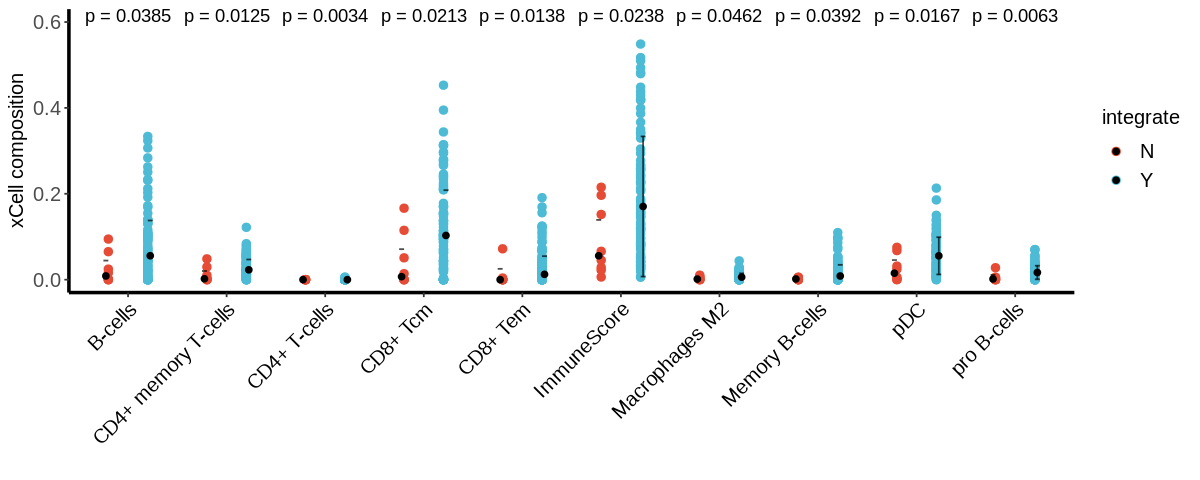

In [132]:
options(repr.plot.width=10, repr.plot.height=4)
pjitter

## D Protein pathscores

In [45]:
library(ggplot2)
library(pacman)
pacman::p_load(tidyverse,ggpubr,rstatix,ggsci,ggsignif,reshape2)

In [56]:
c2 <- read.csv('data/hpv_pathscore_c2.csv',header = T,row.names = 1)

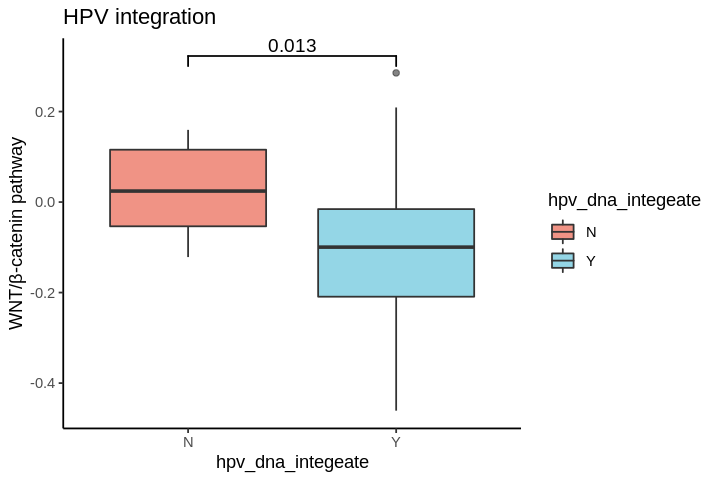

In [47]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data=c2,mapping=aes(x=hpv_dna_integeate,y=`ST_WNT_BETA_CATENIN_PATHWAY`,fill=hpv_dna_integeate))+
geom_boxplot(alpha=0.6)+
scale_fill_npg()+
labs(y = "WNT/β-catenin pathway", title = "HPV integration")+
theme_classic()+
geom_signif(comparisons = list(c('N','Y')),
            map_signif_level=F, 
            textsize=4,test=t.test,step_increase=0.1)

## E Heatmap

In [9]:
load('data/hpv_deseq2_gsea.Rdata')

In [10]:
go=read.csv('data/GO.csv',header=T,row.names=1)
hallmark=read.csv('data/hallmark_genelist.csv',header=T,row.names=1)

In [11]:
diff_rna=deg
colnames(diff_rna)[c(2,5)]=c('logFC_RNA','pvalue_RNA')

In [12]:
IG2=rbind(go[ stringr::str_detect(go$geneset,'EXTRACELLULAR_MATRIX')==TRUE|stringr::str_detect(go$geneset,'WNT')==TRUE,],
       hallmark[ stringr::str_detect(hallmark$geneset,'TGF')==TRUE, ])

In [13]:
IG1=rbind(go[ stringr::str_detect(go$geneset,'IMMUNOGLOBULIN')==TRUE|stringr::str_detect(go$geneset,'B_CELL')==TRUE|
       stringr::str_detect(go$geneset,'HUMORAL_IMMUN')==TRUE, ],
          hallmark[ stringr::str_detect(hallmark$geneset,'INTERFERON')==TRUE|stringr::str_detect(hallmark$geneset,'E2F')==TRUE|
                   stringr::str_detect(hallmark$geneset,'MYC')==TRUE,])

### LOADING EXPR

In [14]:
select=subset(diff_rna,diff_rna$pvalue_RNA<0.05 & diff_rna$logFC_RNA>0)
a1=intersect(rownames(select),IG1$symbol)
select=subset(diff_rna,diff_rna$pvalue_RNA<0.05 & diff_rna$logFC_RNA< 0)
b1=intersect(rownames(select),IG2$symbol)
select1=c(a1,b1)
length(a1)
length(b1)

[1] 172

[1] 68

In [15]:
rnaorder=dplyr::arrange(diff_rna[select1,],logFC_RNA)

In [16]:
library(data.table)
temp <- as.data.frame(fread('data/hpv_rnaselect.csv',header = T))
rownames(temp)<- temp$V1
temp <-temp[-1]

### heatmap clusters annotation

In [17]:
library(clusterProfiler)
library(org.Hs.eg.db)

In [18]:
pathlist<-function(tempg1){
    pathanno=list()
    for(i in 1:nrow(tempg1)){
        tempg1=tempg1[order(-tempg1$Count),]
        test=list(stringr::str_split(tempg1[i,'geneID'],'/')[[1]])
        names(test)<-tempg1$Description[i]
        pathanno=c(pathanno,test)
    }
    return(pathanno)
}

In [19]:
pathanno <- function(genelist,path1){
    df<-data.frame()
    for(i in 1:length(genelist)){
        a=ifelse(genelist[i]%in%path1[[1]], 1,0)
        temp=data.frame(a)
        colnames(temp)=names(path1)[1]
        dat <- temp
        for(j in 2:length(path1)){
                    a=ifelse(genelist[i]%in%path1[[j]], 1,0)
                    temp=data.frame(a)
                    colnames(temp)=names(path1)[j]
                    dat <- cbind(dat,temp)
            }
        df <- rbind(df,dat)
        }
    rownames(df)=genelist
    return(df)
}

In [20]:
tcell=list(go[stringr::str_detect(go$geneset,'GO_T_CELL_ACTIVATION')==TRUE,'symbol']) 
names(tcell)<-c('T cell activation')
bcell=list(go[stringr::str_detect(go$geneset,'GO_B_CELL_ACTIVATION')==TRUE,'symbol']) 
names(bcell)<-c('B cell activation')
ifn=list(c(hallmark[stringr::str_detect(hallmark$geneset,'INTERFERON')==TRUE,'symbol'],go[stringr::str_detect(go$geneset,'GO_TYPE_I_INTERFERON_PRODUCTION')==TRUE,'symbol'])) 
names(ifn)<-c('IFN pathway')

In [21]:
ecm_o=list(go[stringr::str_detect(go$geneset,'EXTRACELLULAR_MATRIX')==TRUE,'symbol']) 
names(ecm_o)<-c('ECM')
wnt=list(go[stringr::str_detect(go$geneset,'WNT')==TRUE,'symbol']) 
names(wnt)<-c('WNT')

In [22]:
adhension=list(go[stringr::str_detect(go$geneset,'GO_CELL_SUBSTRATE_ADHESION')==TRUE,'symbol']) 
names(adhension)<-c('cell adhesion')
morphogenesis <-list(go[stringr::str_detect(go$geneset,'GO_CELL_MORPHOGENESIS')==TRUE,'symbol']) 
names(morphogenesis)<-c('morphogenesis')
develop <-list(go[stringr::str_detect(go$geneset,'TISSUE_DEVELOPMENT')==TRUE,'symbol']) 
names(develop)<-c('tissue development')

In [23]:
cellcycle=list(go[stringr::str_detect(go$geneset,'CELL_CYCLE_PHASE_TRANSITION')==TRUE,'symbol']) 
names(cellcycle)<-c('cell cycle')

In [24]:
e2f=list(hallmark[stringr::str_detect(hallmark$geneset,'E2F')==TRUE,'symbol']) 
names(e2f)<-c('E2F')
g2m=list(hallmark[ stringr::str_detect(hallmark$geneset,'G2M')==TRUE,'symbol']) 
names(g2m)<-c('G2M')
path1=c(ecm_o,adhension,morphogenesis,wnt)
anno1=pathanno(rownames(temp),path1)

In [25]:
path2=c(tcell,bcell,ifn,g2m,e2f,cellcycle)
anno2=pathanno(rownames(temp),path2)

In [26]:
anno1select=anno1[rownames(rnaorder%>%filter(logFC_RNA<=0)),]
anno1select=anno1select%>%arrange(desc(ECM),desc(morphogenesis),desc(WNT))

In [27]:
anno2select=anno2[rownames(rnaorder%>%filter(logFC_RNA>=0)),]
anno2select=anno2select%>%arrange(desc(`T cell activation`),desc(`B cell activation`),desc(`IFN pathway`),desc(G2M),desc(E2F),desc(`cell cycle`))

### anno plot

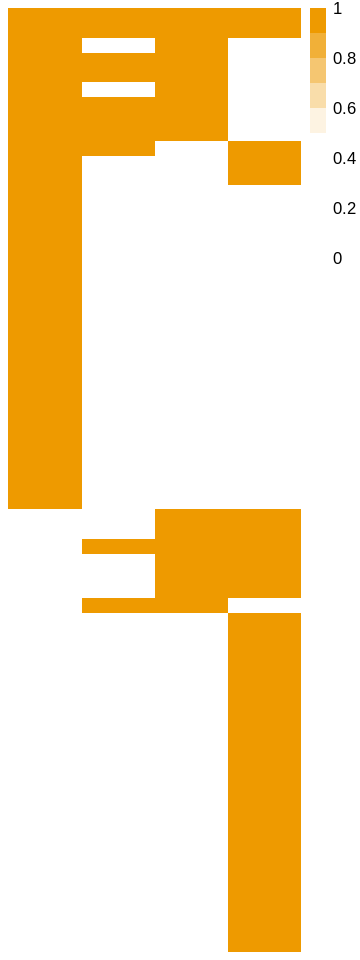

In [33]:
options(repr.plot.width=3, repr.plot.height=8)
library(pheatmap)
anno1select=na.omit(anno1select[rowSums(anno1select)>0,])
panno1=pheatmap(as.matrix(anno1select),width=3,height=4,fontsize_row =4,fontsize_col =4,
         method="none", #计算gene或sample之间的相关性的方法，可选"pearson" (default), "kendall", or "spearman"
         scale="none", #为基因做scale
         cluster_rows=F,#为基因做聚类
         cluster_cols=F,#为sample做聚类
         color = colorRampPalette(colors = c("white","white","orange2"))(10),
         #breaks=bk,
         #gaps_col=c(24),
         #cutree_rows=3,
         show_colnames=F,show_rownames =F,
         #annotation_col=group,
         border_color = "NA")

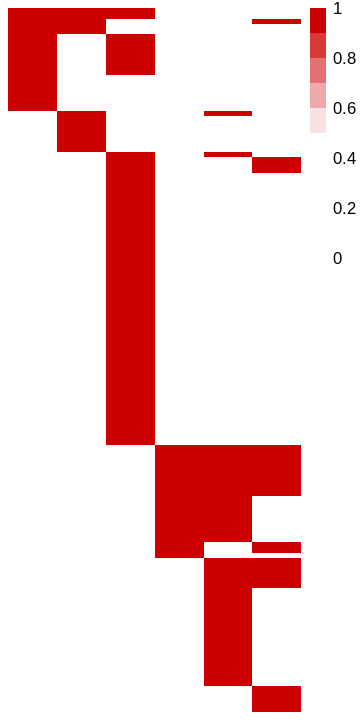

In [34]:
options(repr.plot.width=3, repr.plot.height=6)
anno2select=na.omit(anno2select[rowSums(anno2select)>0,])
panno2=pheatmap(as.matrix(anno2select),width=3,height=6,fontsize_row =4,fontsize_col =4,
         method="none", #计算gene或sample之间的相关性的方法，可选"pearson" (default), "kendall", or "spearman"
         scale="none", #为基因做scale
         cluster_rows=F,#为基因做聚类
         cluster_cols=F,#为sample做聚类
         color = colorRampPalette(colors = c("white","white","red3"))(10),
         #breaks=bk,
         #gaps_col=c(24),
         #cutree_rows=3,
         show_colnames=F,show_rownames =F,
         #annotation_col=group,
         border_color = "NA")

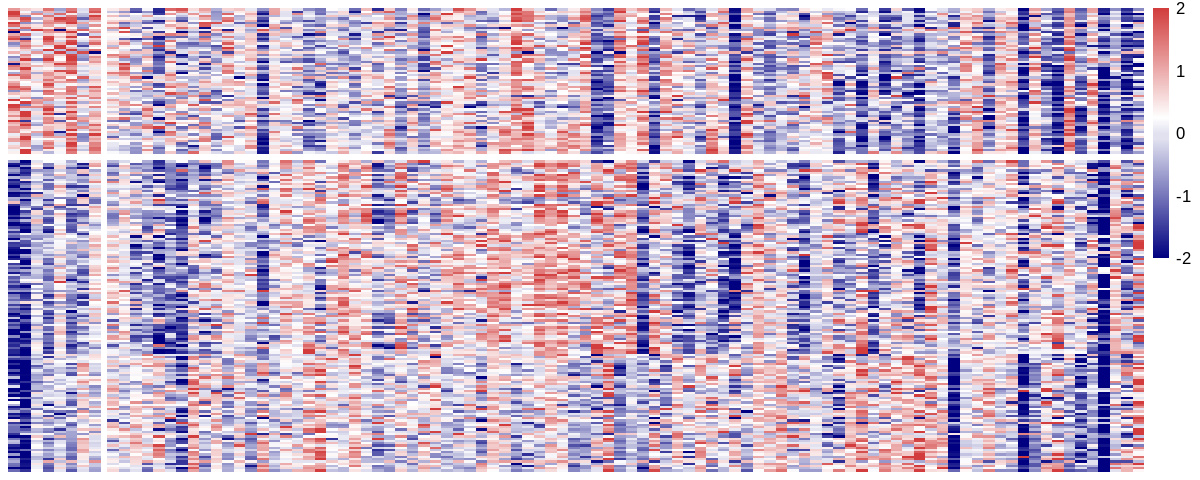

In [36]:
options(repr.plot.width=10, repr.plot.height=4)
bk <- c(seq(-2,-0.1,by=0.01),seq(0,2,by=0.01))
hmr2=pheatmap(temp[c(rownames(anno1select),rownames(anno2select)),],width=10,height=1,fontsize_row =5,
         method="spearman", #计算gene或sample之间的相关性的方法，可选"pearson" (default), "kendall", or "spearman"
         scale="row", #为基因做scale
         cluster_rows=F,#为基因做聚类
         cluster_cols=F,#为sample做聚类
         color = c(colorRampPalette(colors = c("navy","white"))(length(bk)/2+20),
                   colorRampPalette(colors = c("white","firebrick3"))(length(bk)/2)),
         breaks=bk,
         gaps_col=c(8),gaps_row=c(nrow(anno1select)),
         #cutree_rows=2,
         show_colnames=F,show_rownames =F,
         annotation_colors = ann_colors,
         border_color = "NA")

### puzzles

In [37]:
library(cowplot)

In [38]:
options(repr.plot.width=7, repr.plot.height=7)
p1=plot_grid(panno1$gtable,panno2$gtable, nrow=2, rel_heights = c(1, nrow(anno2select)/nrow(anno1select))) #Or labels="AUTO"

In [39]:
options(repr.plot.width=8, repr.plot.height=4)
hpv_prna=plot_grid(hmr2$gtable, p1, nrow=1, rel_widths  = c(1, 0.3)) #Or labels="AUTO"

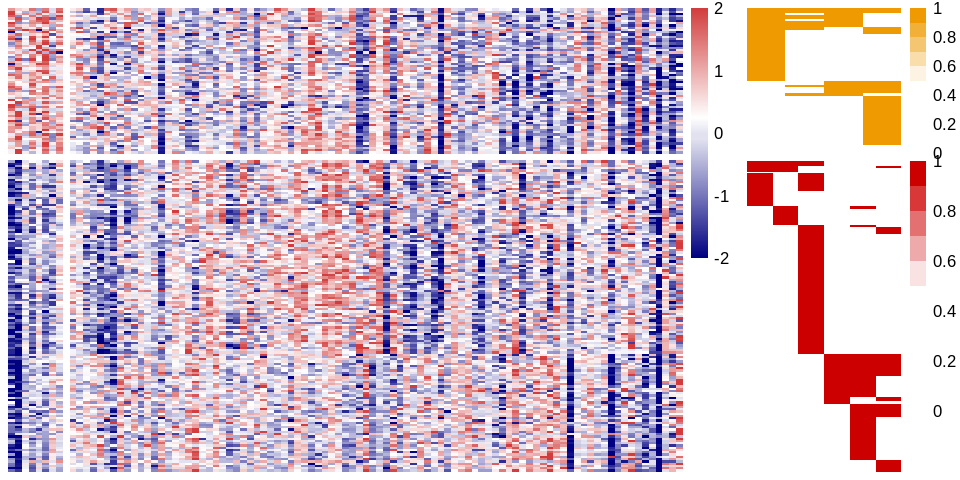

In [40]:
hpv_prna

## F Axis for logFC
The logFC was derived as mentioned above.

In [123]:
library(ggrepel)
library(ggthemes)
library(ggsci)
library(ggplot2)
library(ggpubr)
library(ggpmisc)

In [116]:
data <- read.csv('data/hpv_rna_protein_logfc.csv',header = T,row.names = 1)

In [117]:
data$size=ifelse(data$group=='stable',0.5,abs(data$logFC_RNA)*1.2)
data$alpha=ifelse( data$group=='stable',0.1,0.4)
data$group=factor(data$group,level=c('stable','RNA_sig','double_sig','protein_sig'))

In [120]:
selectb=c("AGRN","LAMC1","MCAM" ,"PARVA",
         "AGO1","CUL3","DVL1",
         "DPYSL3","NRP2",'TP53','PARVA')
selectb=data.frame(Row.names=selectb,anno=c(rep('Adhesion',4),rep('WNT',3),rep('morphogenesis',4)))

In [121]:
selecta=c("CDK1","CDKN2A","AIF1","PCNA",'PARP9','SMCHD1',
          "HLA-A","HLA-DRA","IFIT3","OAS2","STAT1",'FCER1G','GBP5')
selecta=data.frame(Row.names=selecta,anno=c(rep('Cell cycle',6),rep('Immunity',7)))
select=rbind(selecta,selectb)

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


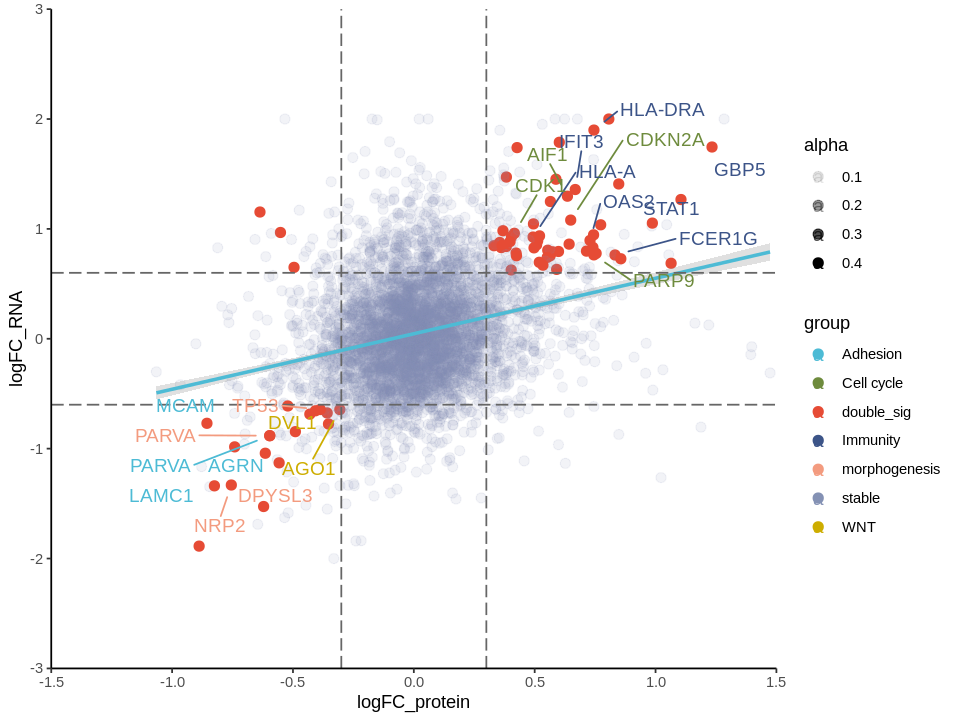

In [122]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data=data,aes(x=logFC_protein, y=logFC_RNA,color=group,alpha=alpha))+geom_point(size=2.5)+
stat_smooth(method='lm',formula = y~x,colour='#4DBBD5FF',alpha=0.3)+
labs(x = "logFC_protein", y = "logFC_RNA")+
  theme_classic()+scale_size_continuous(range=c(0,3))+
  scale_x_continuous(limits = c(-1.5,1.5),expand = c(0,0))+
  scale_y_continuous(limits = c(-3,3),expand = c(0,0)) +
geom_vline(xintercept = c(-0.3,0.3), color="grey40", 
             linetype="longdash", lwd = 0.5) + #虚线的形状和粗细
geom_hline(yintercept = c(-0.6,0.6), color="grey40", 
             linetype="longdash", lwd = 0.5)+ 
geom_text_repel(aes(x=logFC_protein, y=logFC_RNA,label = ifelse(Row.names%in%select$Row.names&group=='double_sig',Row.names,''),color=factor(anno)),
          box.padding = unit(0.35, "lines"),size=4,max.overlaps=500,direction='both',
        point.padding = unit(1, "lines"))+
scale_color_manual(values=c('#4DBBD5FF','darkolivegreen4',pal_npg()(1),'#3C5488FF','#F39B7FFF','#8491B4FF','gold3'))

# Figure 4
## A logistic regression

In [50]:
dat<-read.csv('data/clinic_metadata.csv',header = T)
dat$integrate=as.factor(dat$integrate)

In [51]:
b=glm(integrate~Cerv_Mus_Dep+Age+Stage+Grade+Diagram_4cm,data=dat, family = binomial)
summary(b)


Call:
glm(formula = integrate ~ Cerv_Mus_Dep + Age + Stage + Grade + 
    Diagram_4cm, family = binomial, data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2982  -0.9356   0.5060   0.7038   1.4171  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)       6.30418    2.08512   3.023  0.00250 **
Cerv_Mus_Dep     -0.26797    0.31908  -0.840  0.40100   
Age              -0.10812    0.03705  -2.918  0.00352 **
StageII-III       1.71587    0.63944   2.683  0.00729 **
GradeG3          -0.77241    0.58197  -1.327  0.18443   
Diagram_4cmsmall  0.51137    0.80906   0.632  0.52735   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 101.178  on 84  degrees of freedom
Residual deviance:  84.463  on 79  degrees of freedom
  (5 observations deleted due to missingness)
AIC: 96.463

Number of Fisher Scoring iterations: 4


In [52]:
c <- as.data.frame(summary(b)$coefficients)
c$factor=rownames(c)
c$odd_ratio<-exp(coef(b))

In [53]:
bb<-exp(confint(b))
c <- cbind(c,bb)
c <- as.data.frame(c[-1,])
c$sig<-ifelse(c$`Pr(>|z|)`>=0.05,'nosig',ifelse(c$odd_ratio>1,'Active','Silent'))

Waiting for profiling to be done...



In [54]:
c$CI=paste('[',round(c$`2.5 %`,3),',',round(c$`97.5 %`,3),']',sep='')

In [55]:
c

,Estimate,Std. Error,z value,Pr(>|z|),factor,odd_ratio,2.5 %,97.5 %,sig,CI
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Cerv_Mus_Dep,-0.2679727,0.3190796,-0.8398303,0.401003520,Cerv_Mus_Dep,0.7649286,0.3988977,1.4170787,nosig,"[0.399,1.417]"
Age,-0.1081231,0.0370527,-2.9180900,0.003521827,Age,0.8975171,0.8287646,0.9597236,Silent,"[0.829,0.96]"
StageII-III,1.7158664,0.6394429,2.6833773,0.007288272,StageII-III,5.5614921,1.6960711,21.3802578,Active,"[1.696,21.38]"
GradeG3,-0.7724112,0.5819693,-1.3272371,0.184430271,GradeG3,0.4618980,0.1407643,1.4118878,nosig,"[0.141,1.412]"
Diagram_4cmsmall,0.5113726,0.8090573,0.6320598,0.527347788,Diagram_4cmsmall,1.6675786,0.3183436,8.1265066,nosig,"[0.318,8.127]"


In [56]:
annotation <- data.frame(x=rep(50,6),y=c( 5.5, 5, 4, 3, 2, 1),
                         label=c('P Value', round(c$`Pr(>|z|)`,3)))

In [57]:
library(ggsci)

In [58]:
options(repr.plot.width=5,repr.plot.height=5)
p=ggplot(c, aes(x=odd_ratio,y=factor))+ 
geom_point(size=6, aes(col=sig)) +
scale_color_npg()+
geom_errorbarh(aes(xmax = `97.5 %`, xmin = `2.5 %`), height = 0.2)+
geom_vline(aes(xintercept = 1))+theme(legend.position = "top")+
scale_x_continuous(trans = "log10",limits=c(0.01, 40), breaks = c(0, 0.5,1, 10,30,100))+
xlab('Odds Ratio') + ylab(" ")+theme_bw() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

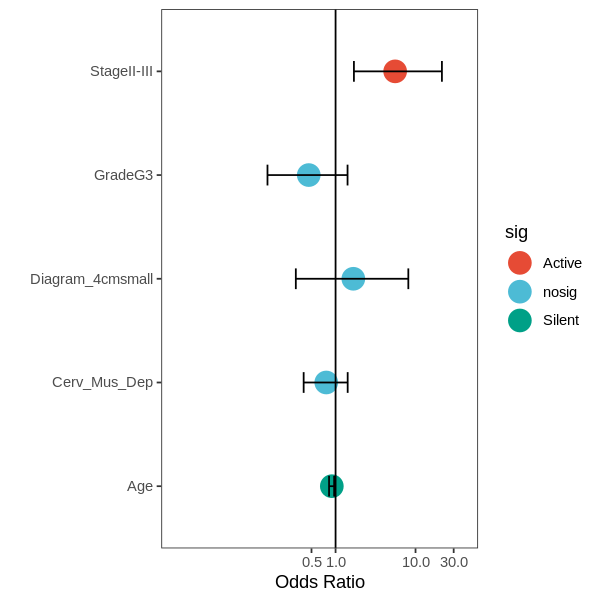

In [59]:
p

## Others
Similar codes in Figure 3